# Salem paper attacks

This notebook showcases the three different scenarios presented in Salem *et al.* [ML-Leaks: Model and Data Independent Membership Inference Attacks and Defenses on Machine Learning Models](https://arxiv.org/abs/1806.01246).

In summary the three presented adversaries are as follows:
1. The attacker has access to a dataset drawn from the same distribution as the target data, and uses it to train a single shadow model that infers the membership information.
2. The attacker uses a dataset from a different distribution than the target data to do the same as Adv 1.
3. The attacker queries the target model and chooses a threshold on the classification probability to determine membership, no shadow models required.

In [1]:
import sys
import os

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("")))
sys.path.append(ROOT_DIR)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Scikit-learn utils
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

# Classifiers for attack models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


In [3]:
#import t=privachy version 
import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy


### Definition of the datasets
1. We draw data points from a distribution.
2. We split these data points into the target dataset and a shadow dataset drawn from the same distribution.
3. We also draw a dataset from a different distribution.

**NOTE**. ***I make datasets with few samples but with many features to force the target model to overfit.***


***NOTE JIM: had to make batch_size 25 so DP optimizer would run with same hyperparams

In [4]:
n_classes = 2

# (X,y): Original distribution
X, y = make_classification(n_samples=1000,
                           n_classes=n_classes, 
                           n_features=300,
                           n_informative=300,
                           n_redundant=0,
                           n_repeated=0,
                           random_state=15
                          )
# One-hot encoding of the label
y = np.eye(n_classes)[y]

# (Xt, yt) is the target dataset, owned by the TRE and drawn from the (X,y) distribution
# (Xs, ys) is a shadow dataset drawn from the (X,y) distribution
Xt, Xs, yt, ys = train_test_split(X, y, test_size=0.50, random_state=15)

# (Xd, yd) is a shadow dataset, drawn from a different distribution (different seed)
Xd, yd = make_classification(n_samples=1000,
                           n_classes=n_classes, 
                           n_features=300,
                           n_informative=300,
                           n_redundant=0,
                           n_repeated=0,
                           random_state=42
                          )
yd = np.eye(n_classes)[yd]




### Train the target model

*Again, I'm using a rather big model (for the classification task) to favour overfitting.*

In [5]:
# Split into train (member) and test (non-member) datasets
# Set shuffle to False so that Xt_membership is consistent with Xt, otherwise
# we need to stack Xt_member and Xt_nonmember again to get a consistent Xt.
Xt_member, Xt_nonmember, yt_member, yt_nonmember = train_test_split(Xt, yt, test_size=0.5, shuffle=False)

# Set membership status for future tests
Xt_membership = np.vstack(
    (
        np.ones((Xt_member.shape[0], 1), np.uint8),
        np.zeros((Xt_nonmember.shape[0], 1), np.uint8)
    )
).flatten()

In [6]:
# Define target model
# Tensorflow model (MLP) (making it big to make it overfit)
input_data = Input(shape = Xt_member[0].shape)
x = Dense(128, activation='relu')(input_data)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

Metal device set to: Apple M1 Pro


2022-05-13 11:12:55.097193: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-13 11:12:55.097318: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
target_model = Model(input_data, output)
target_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


batch_size=25
epochs = 10

# Train target model
r = target_model.fit(Xt_member, 
                     yt_member, 
                     validation_data=(Xt_nonmember, yt_nonmember),
                     epochs=epochs, 
                     batch_size=batch_size
                    )  

Epoch 1/10


2022-05-13 11:12:58.197051: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-13 11:12:58.348635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 29ms/step - loss: 1.9923 - accuracy: 0.5240 - val_loss: 1.5158 - val_accuracy: 0.6040
Epoch 2/10
 5/10 [==============>...............] - ETA: 0s - loss: 0.5852 - accuracy: 0.8000

2022-05-13 11:12:58.662793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 19ms/step - loss: 0.4068 - accuracy: 0.8640 - val_loss: 1.3223 - val_accuracy: 0.5840
Epoch 3/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0656 - accuracy: 0.9800 - val_loss: 1.2181 - val_accuracy: 0.6560
Epoch 4/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0215 - accuracy: 1.0000 - val_loss: 1.2105 - val_accuracy: 0.6560
Epoch 5/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 1.2162 - val_accuracy: 0.6200
Epoch 6/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 1.2330 - val_accuracy: 0.6160
Epoch 7/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.2302 - val_accuracy: 0.6240
Epoch 8/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2319 - val_accuracy: 0.6360
Epoch 9/10
10/10 [======

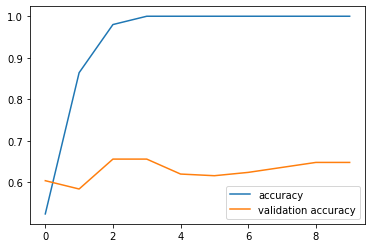

In [8]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()


**SUCCESS. The model overfits a lot.**

## So now let's see what we can find out about this model if it is exported just be querying it

In [ ]:
target_model.__dict__

### in particular, as well as all the config details and weights, we can see this was not compiled with the DP version of the optimiser
 - and if we print target_model.optimizer.__dict__ we get even mor detail

In [ ]:

print(f'trained model has this type of optimiser {type(target_model.optimizer)}')
print( 'and the loss function is {target_model.loss}')
print(target_model.optimizer._name)

saved_nonDP_optimiser_dict= target_model.optimizer.__dict__

test_loss, test_acc = target_model.evaluate(Xs,  ys, verbose=2)
print(f'before hacking the model attributes test loss is {test_loss} test accuracy is {test_acc}')



### so ...
We could easily:
- write a code that tested the model looking to see if it used for the DP optimiser 
- make it available via `preliminaryCheck()` and `requestRelease()`

But what if a researcher tries to change the optimiser afterwards, but forgets to retrain?

**Q** check if malicious user could change min_split_size perior to calling fit() then change back afterwards in sklearn safe version


**panicking user follows advice from** https://www.tensorflow.org/responsible_ai/privacy/tutorials/classification_privacy

- define some params
- Define the optimizer and loss function for the learning model. 

- Compute the loss as a vector of losses per-example rather than as the mean over a minibatch to support gradient manipulation over each training point.

In [9]:
###user manually creates DP optimiser and resets model
#some params
l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = batch_size
learning_rate = 0.25


if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

#create the optimiser and loss function

optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

In [ ]:
# now try to manually assign these values to the target_model rather than recompile and refit
import copy
hacked_model = copy.deepcopy(target_model)

hacked_model.optimizer = optimizer
hacked_model.loss = loss

# so what have we got now?

print(f'After hacking the model attributes it now looks like the same trained model has this type of optimiser {hacked_model.optimizer}')


# can we still use it for prediction even after this hacking?
test_loss, test_acc = hacked_model.evaluate(Xs,  ys, verbose=2)
print(f'\n But, importantly, we can still use it to predict: test loss is {test_loss} test accuracy is {test_acc}')





### This is what they would have got if they recompiled and reran


Epoch 1/10


2022-05-13 11:14:01.608052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 4s 286ms/step - loss: 202999.1719 - accuracy: 0.5360 - val_loss: 224314.0938 - val_accuracy: 0.5480
Epoch 2/10


2022-05-13 11:14:04.599245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 3s 296ms/step - loss: 248961.1250 - accuracy: 0.5800 - val_loss: 249395.8750 - val_accuracy: 0.5800
Epoch 3/10
10/10 [==============================] - 3s 309ms/step - loss: 289778.3438 - accuracy: 0.5720 - val_loss: 302644.2500 - val_accuracy: 0.5240
Epoch 4/10
10/10 [==============================] - 3s 307ms/step - loss: 345727.3125 - accuracy: 0.5600 - val_loss: 421453.6875 - val_accuracy: 0.5000
Epoch 5/10
10/10 [==============================] - 3s 286ms/step - loss: 405198.3750 - accuracy: 0.5400 - val_loss: 566919.8750 - val_accuracy: 0.4600
Epoch 6/10
10/10 [==============================] - 3s 275ms/step - loss: 453057.3750 - accuracy: 0.5640 - val_loss: 672357.8125 - val_accuracy: 0.5200
Epoch 7/10
10/10 [==============================] - 3s 290ms/step - loss: 451907.1562 - accuracy: 0.6240 - val_loss: 637892.1875 - val_accuracy: 0.5120
Epoch 8/10
10/10 [==============================] - 3s 317ms/step - loss: 544608.5000 - accuracy: 0

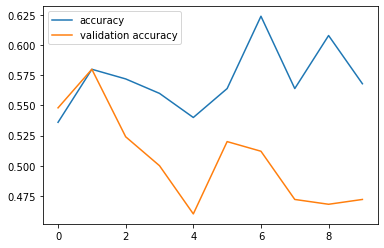

16/16 - 0s - loss: 880922.6875 - accuracy: 0.5420 - 202ms/epoch - 13ms/step

 The DP trained version gets these test results:  test loss is 880922.6875 test accuracy is 0.5420000553131104
trained model has this type of optimiser <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>
and the loss function is {target_model_DP.loss}


2022-05-13 11:14:31.720378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [11]:


#some params
l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = batch_size
learning_rate = 0.25




if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

#create the optimiser and loss function

optimizer = tensorflow_privacy.DPKerasAdamOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, reduction=tf.losses.Reduction.NONE)

DP_model = Model(input_data, output)
DP_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])




r_DP = DP_model.fit(Xt_member, 
                     yt_member, 
                     validation_data=(Xt_nonmember, yt_nonmember),
                     epochs=epochs, 
                     batch_size=batch_size
                    )  
                    
plt.plot(r_DP.history['accuracy'], label='accuracy')
plt.plot(r_DP.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()                    
                    
                    
test_loss, test_acc = DP_model.evaluate(Xs,  ys, verbose=2)
print(f'\n The DP trained version gets these test results:  test loss is {test_loss} test accuracy is {test_acc}')


print(f'trained model has this type of optimiser {type(DP_model.optimizer)}')
print( 'and the loss function is {target_model_DP.loss}')
  

## Checks for differential privacy based on flags within model optimizer

In [ ]:
#show that DP was not used
def check_DP_used(optimizer):
    DPused = False
    reason = "None"
    if ( "_was_dp_gradients_called" not in optimizer.__dict__ ):
        reason = "optimiser does not contain key _was_dp_gradients_called so is not DP."
        DPused = False
    elif (optimizer._was_dp_gradients_called==False):
        reason= "although the target model optimiser has been changed to a DP variant, fit() has not been rerun."
        DPused = False
    else:
        reason= f" value of the key: target_model.optimizer._was_dp_gradients_called is {optimizer._was_dp_gradients_called} so DP variant of optimiser has been run"
        DPused=True
    return DPused, reason

## So what have we learned?

In [ ]:
print("=====For our original non-DP model=====")
the_optimiser = target_model.optimizer
print(f"The optimiser is of type {type(the_optimiser)}, with name {the_optimiser._name}.")
print(f"calling get_config() on this optimizer returns {the_optimiser.get_config()}")
value, reason = check_DP_used(the_optimiser)
print(f"Running our check_DP_used function  gives {value} because {reason}\n")

print(f"=====For the hacked version of original non-DP model=====")
the_optimiser = hacked_model.optimizer      
print(f"The optimiser is of type {type(the_optimiser)}, with name {the_optimiser._name}.")
print(f"calling get_config() on this optimizer returns {the_optimiser.get_config()}")
value, reason = check_DP_used(the_optimiser)
print(f"Running our check_DP_used function  gives {value} because {reason}\n")

print("=====For the DP model =======")
the_optimiser= DP_model.optimizer
print(f"The optimiser is of type {type(the_optimiser)}, with name {the_optimiser._name}.")
print(f"calling get_config() on this optimizer returns {the_optimiser.get_config()}")
value, reason = check_DP_used(the_optimiser)
print(f"Running our check_DP_used function  gives {value} because {reason}\n")

In [ ]:
from typing import Any

def check_type(key: str, val: Any, cur_val: Any) -> tuple[str, bool]:
    """Checks the type of a value"""
    print(type(DP_model.optimizer))
    if isinstance(cur_val, val) == False:
        disclosive = True
        msg = (
            f"- parameter {key} = {cur_val}"
            f" identified as different type than the recommended fixed value of {val}."
        )
    else:
        disclosive = False
        msg = ""
    return msg, disclosive



print()
check_type(key="optimizer", val=tensorflow_privacy.DPKerasSGDOptimizer,cur_val = DP_model.optimizer)


### so the test accuracy is now significantly reduced if they properly recompile and retrain using the DP code

### and what is the nominal privacy?

In [ ]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=Xt.shape[0],
                                              batch_size=batch_size,
                                              noise_multiplier=noise_multiplier,
                                              epochs=epochs,
                                              delta=1e-5)

## Now try the SafeKerasModel version

In [14]:
import importlib
import safemodel
from safemodel.classifiers.safekeras import Safe_KerasModel



importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel



In [15]:
optimizer=None
safeModel = Safe_KerasModel(inputs= input_data, outputs=output)


args is a <class 'tuple'> = ()  kwargs is a <class 'dict'>= {'inputs': <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'input_1')>, 'outputs': <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_3')>}
- parameter optimizer = None identified as different type to recommendation of tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass.Nothing currently implemented to change type of parameter optimizer from NoneType to tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass.



In [16]:
#safeModel.__dict__


In [17]:
safeModel.compile()#optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(safeModel.optimizer)



<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x28e367190>


In [24]:
theType= type(safeModel.optimizer)
print(f'optimiser is type {theType}')

print (f'{type(tensorflow_privacy.privacy.optimizers.dp_optimizer_keras)}')
print(f' {issubclass(theType,tensorflow_privacy.privacy.optimizers.dp_optimizer_keras)}')

optimiser is type <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>
<class 'module'>


TypeError: issubclass() arg 2 must be a class or tuple of classes

In [ ]:
l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = batch_size
learning_rate = 0.25




if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

#create the optimiser and loss function

optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

In [ ]:
safeModel.fit(Xt_member, 
              yt_member, 
              validation_data=(Xt_nonmember, yt_nonmember),
              epochs=epochs, 
              batch_size=batch_size
)  


In [ ]:
safeModel.save('safekeras.sav')

In [ ]:
safeModel.preliminary_check()

In [ ]:
safeModel.request_release('safekeras.pkl')

In [ ]:
# create and fit using recommended params
print("***Test 1: researcher doesn't change recommended params")
safeKerasModel1 = Safe_KerasModel(input_data, output)
safeKerasModel1.compile()
safeKerasModel1.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel1.save(name="safe1.pkl")
safeKerasModel1.preliminary_check()
safeKerasModel1.request_release(filename="safe1.pkl")


# change model params to recommended values
print("\n***Test 2: researcher changes params safely")
safeKerasModel2 = Safe_KerasModel(input_data, output)
safeKerasModel2.compile()
safeKerasModel2.optimizer="DPAdam"
safeKerasModel2.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel2.save(name="safe2.pkl")
safeKerasModel2.preliminary_check()
safeKerasModel2.request_release(filename="safe2.pkl")

# change one model params in an unsafe way
print("\n***Test 3: researcher changes string params unsafely")
safeKerasModel3 = Safe_KerasModel(input_data, output)
safeKerasModel3.compile()
safeKerasModel3.optimizer="Adam"
safeKerasModel3.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel3.save(name="unsafe3.pkl")
safeKerasModel3.preliminary_check()
safeKerasModel3.request_release(filename="unsafe3.pkl")

# change another model params in an  unsafe way


# change another model params in an  unsafe way
print("\n***Test 5: researcher changes string and numeric params unsafely")


In [ ]:
# change another model params in an  unsafe way but tells preliminary_check() not to overwrite params
print("\n***Test 6: researcher changes string and numeric params unsafely")
safeKerasModel6 = Safe_KerasModel(input_data, output)
safeKerasModel6.compile()
safeKerasModel6.optimizer="Adam"
safeKerasModel6.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel6.save(name="unsafe6.pkl")
safeKerasModel6.preliminary_check(apply_constraints=False)
safeKerasModel6.request_release(filename="unsafe6.pkl")